# Similarity and recommendation

In this notebook we will explore similarity between Danish politicians based on how they communicate on the social platform Twitter. The similarity will be Jaccard similarity calculated using minhashing on TF-IDFs of all tweets, the politicians have tweeted, and the similarity is lastly visualized as a heatmap. We expect politicians from the same political party to have a higher similarity than politicians of different parties. (The possibility of two politicians with contradicting views on a topic is present, and whether these will end up similar is very interesting to investigate). 


Additionally, we will create a recommendation system using Location-Sensitive hashing (LSH) imitating the well-known Danish ‘candidate test’ (https://www.dr.dk/nyheder/politik/folketingsvalg/kandidattest). The candidate test is used by most citizens prior to the governmental elections, to help them determine which politician to vote for, as the outcome of the test is a list of the politicians, they agree the most with on numerous topics based on a questionnaire. Our recommendation system will provide the top 3 most similar politicians of a test subject with a known political standpoint. (maybe something with the fact that we do not know if the test subjects twitter profiles reflect their political standpoint and the use of sarcasm, irony etc. which is widely used in the Danish language. 

### Jaccard similarity

The similarity we will apply in this notebook is the Jaccard similarity, which states that the similarity of sets is based on the relative size of their intersections. Hence, the Jaccard similarity of sets A and B is |A n B| / |A u B|.  In this notebook we investigate the textualy similar sets of tweets in the large corpus of collected tweets by the politicians. Since we are working on tweets, the similarity of these is on the character level and not in the sense of what meaning they convey, so we are not actually extracting any semantic meaning of the tweets. Hence, when irony and sarcasm as literary devices where there is difference between what the content appears to mean versus its literal meaning is being used, the similarity score will be larger than it should be. As irony and sarcasm is widely used in the Danish language, we expect some this to impact the accuracy of our similarity scoring and recommendation negatively.     


We have chosen to look at the similarity based on the tf-idf words of each politician's collected tweets in order to work at a more content based level rather than context based level. 

### TF-IDF?

### Minhashing and the signature matrix

(The goal of MinHash is to estimate J(A,B) quickly, without explicitly computing the intersection and union.)
Our collected data set of tweets is not considered a rather large data set, but non the less, for the sake of theoretical application and hypothetic scalability we will be using minhashing as a way to convert large sets into much smaller representations for optimization purpose. These smaller sets are called signatures. We can then compare the signatures of two sets and estimate the Jaccard similarity of the underlying sets from the signatures alone. 

The signatures are composed by the results of 300 calculations each of which is a “minhash” of the collected TF-IDFS. ...


### Recommendation systems

different form week 5 due to the tf-idfs bla bla 

In [ ]:
pip install mmh3

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Data and setup

Before diving into the similarity scores, initial setup, and load of data is performed. The data contains cleaned tweets, i.e. stopwords and punctuation among others have been removed.

In [ ]:
%load_ext autoreload
%autoreload 2
!python -m pip install -r requirements.txt
from utils.initialization import *
import sys
import os
import mmh3
from sklearn.feature_extraction.text import TfidfVectorizer



# with mrjob
# names, party and twitter id
from Data.twitter_ids import twitter_ids
data = pd.DataFrame(columns=['name', "party", 'twitter_id'])
i = 0
for party in twitter_ids:
    for person in twitter_ids[party]:
        data.loc[i, :] = [person, party, twitter_ids[party][person]]
        i += 1

# tweets
filename = "Data/cleaned_data.csv"
if not os.path.exists(filename):
    os.system(f"python utils/clean_data_mrjob.py Data/tweets > Data/tmp_cleaned_data.txt")
    data_ = pd.DataFrame(columns=["name", "tweets"])
    with open("Data/tmp_cleaned_data.txt", "rb") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            line = eval(line.decode())
            data_.loc[i,"name"] = list(line.keys())[0]
            data_.loc[i, "tweets"] = list(line.values())[0]
    data_.to_csv(filename, index = False)

data_ = pd.read_csv(filename)
data = data.merge(data_)
data.tweets = [eval(t) for t in data.tweets]
data["tokens"] = [[w for w in word_tokenize(" ".join(data["tweets"][i])) if w.isalnum()] for i in range(len(data))]
# import simplemma #use simplemma instead of nltk.WordNetLemmatizer()          ### vi har addet denne linje
# data["tokens"] = [[simplemma.lemmatize(w, lang='da') for w in data["tokens"][i]] for i in range(len(data))] ### vi har addet denne linje

data


You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,name,party,twitter_id,tweets,tokens
0,magnus_heunicke,socialdemokratiet,22695562,[afsætte år styrke hjælp barn pårørende alvorl...,"[afsætte, år, styrke, hjælp, barn, pårørende, ..."
1,nicolai_wammen,socialdemokratiet,2803948786,[dag siden sige nytte ejendomsvurderingssystem...,"[dag, siden, sige, nytte, ejendomsvurderingssy..."
2,mattias_tesfaye,socialdemokratiet,546254893,[literally logic many th c americans north sou...,"[literally, logic, many, th, c, americans, nor..."
3,jakob_ellemann,venstre,155584627,[tide få fleksibel genåbning vores barn ældre ...,"[tide, få, fleksibel, genåbning, vores, barn, ..."
4,soren_gade,venstre,975064362359623680,[kære marianne syne burde læse lovforslag inte...,"[kære, marianne, syne, burde, læse, lovforslag..."
5,sophie_lohde,venstre,44611200,[flertal veto dermed rød parti stor se støtte ...,"[flertal, veto, dermed, rød, parti, stor, se, ..."
6,lars_lokke,moderaterne,26201346,[mon sjov form argumentation mangle lidt faktu...,"[mon, sjov, form, argumentation, mangle, lidt,..."
7,jakob_engel_schmidt,moderaterne,337779051,"[før smide fornærmelse læ lige igen skrive, la...","[før, smide, fornærmelse, læ, lige, igen, skri..."
8,monika_rubin,moderaterne,2875249253,[barn udsætte tvinge barnebarn ungdomspsykiatr...,"[barn, udsætte, tvinge, barnebarn, ungdomspsyk..."
9,jacob_mark,sf,2373406198,[slå faste syvtommersøm komme godte igennem fo...,"[slå, faste, syvtommersøm, komme, godte, igenn..."


Test subjects are being removed form the data.  

In [ ]:
exclude = ['Anders_Bjarklev', 'Anders_Lund_Madsen', 'DTU', 'Michael_Kristiansen',
            'Peter_Mogensen', 'Selma_Montgomery']

# make a dataframe of the excluded names
excluded_df = data[data.name.isin(exclude)]

data = data[~data.name.isin(exclude)]   

## Minhashing 

In [ ]:
def listhash(l,seed):
	val = 0
	for e in l:
		val = val ^ mmh3.hash(e, seed)
	return val 
    
def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = None
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

## Signature dictonary

In [ ]:
k=300

def signature(df, dict_docs, num_hashes, on_what):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document id’s as keys and signatures as values
    """
    dict_signatures = {}
    total_texts = len(list(dict_docs.keys()))
    counter = 1
    for key,text in dict_docs.items():
        print(f'{counter}/{total_texts} - {key} - Processing...')
        doc_shingles = df[on_what][counter-1]
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[key] = minhash_values
        counter += 1
    return dict_signatures



## Jaccard similarity

The notion of similarity adopted in this project the same of mmds in capter 3 - similarity of sets is based on the relative size of their intersections, and this is exactly the Jaccard similarity. Hence, the Jaccard similarity of sets A and B is |A n B| / |A u B|. 

In [ ]:
def jaccard(name1, name2, signature_dict):
    """
    Input:
        - name1 (str): key of the first document S
        - name2 (str): key of the second document T
        - signatures_dict (dict of str:list): dictionary of signatures
    Return: Jaccard similarity between S and T
    """
    signatures_doc1 = np.array(signature_dict[name1])
    signatures_doc2 = np.array(signature_dict[name2])
    # return np.sum(signatures_doc1 == signatures_doc2) #/ len(signatures_doc1)
    return len(np.intersect1d(signatures_doc1, signatures_doc2))/len(np.union1d(signatures_doc1, signatures_doc2))#, np.setdiff1d(signatures_doc1, signatures_doc2)

def similar(signatures_dict, jaccard_threshold=0.001):
    """
    Input:
        - signatures_dict (dict of str:list): dictionary of signatures
        - jaccard_threshold (float): lower bound for Jaccard similarity score to consider
            two documents as similar
    Return: dictionary of similar items
    """
    list_keys = list(signatures_dict.keys())
    similar_items = {}
    for i in range (len(list_keys)-1):
        for j in range (i+1, len(list_keys)):
            similarity_score = jaccard(list_keys[i], list_keys[j], signatures_dict)
            if similarity_score >= jaccard_threshold:
                similar_items[(list_keys[i], list_keys[j])] = similarity_score
    return similar_items

In [ ]:
# for every person, return the 3 people most similar to him/her
def most_similar_persons(similar_items, num_similar_persons=3):
    """
    Input:
        - similar_items (dict of tuple:str): dictionary of similar items
        - num_similar_persons (int): number of similar persons to return
    Return: dictionary of most similar persons
    """
    most_similar_persons = {}
    for key,value in similar_items.items():
        if key[0] not in most_similar_persons:
            most_similar_persons[key[0]] = [(key[1], value)]
        else:
            most_similar_persons[key[0]].append((key[1], value))
        if key[1] not in most_similar_persons:
            most_similar_persons[key[1]] = [(key[0], value)]
        else:
            most_similar_persons[key[1]].append((key[0], value))
    for key,value in most_similar_persons.items():
        most_similar_persons[key] = sorted(value, key=lambda x: x[1], reverse=True)[:num_similar_persons]
    return most_similar_persons


## Table of similarity

In [ ]:


def create_sim_table(df, level, on):
    if on == 'TFIDF_Words':
        vectorizer = TfidfVectorizer(max_df=0.5, max_features=700, stop_words='english')
        vectors = vectorizer.fit_transform(df.tokens.apply(lambda x: " ".join(x)))
        dict_of_tokens={i[1]:i[0] for i in vectorizer.vocabulary_.items()}
        tfidf_vectors = []  # all deoc vectors by tfidf
        for row in vectors:
            tfidf_vectors.append({dict_of_tokens[column]:value for (column,value) in zip(row.indices,row.data)})
        df['TFIDF_Words'] = [list(tfidf_vectors[i].keys()) for i in range(len(df))]
    elif on == 'tokens':
        pass
    
    dict_docs = {i:j for i,j in zip(df[level],df[on])}
    signature_dict = signature(df, dict_docs, num_hashes = 300, on_what = on)
    found_similar_items = similar(signature_dict)
    most_similar_items = sorted(found_similar_items.items(), key=lambda x: x[1], reverse=True)
    most_similar_persons_res = most_similar_persons(found_similar_items)

    # convert most_similar_persons_res to a datamframe for easier visualization
    most_similar_persons_df = pd.DataFrame.from_dict(most_similar_persons_res, orient='index')
    if level == 'name':
        most_similar_persons_df.columns = ['Most similar person 1', 'Most similar person 2', 'Most similar person 3']
    elif level == 'party':
        most_similar_persons_df.columns = ['Most similar party 1', 'Most similar party 2', 'Most similar party 3']
    return most_similar_persons_df



In [ ]:
# for each politician 
create_sim_table(data, 'name','TFIDF_Words')

/tmp/ipykernel_746/116957002.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TFIDF_Words'] = [list(tfidf_vectors[i].keys()) for i in range(len(df))]
1/36 - magnus_heunicke - Processing...
2/36 - nicolai_wammen - Processing...
3/36 - mattias_tesfaye - Processing...
4/36 - jakob_ellemann - Processing...
5/36 - soren_gade - Processing...
6/36 - sophie_lohde - Processing...
7/36 - lars_lokke - Processing...
8/36 - jakob_engel_schmidt - Processing...
9/36 - monika_rubin - Processing...
10/36 - jacob_mark - Processing...
11/36 - pia_dyhr - Processing...
12/36 - kirsten_andersen - Processing...
13/36 - dennis_flydtkjær - Processing...
14/36 - peter_skaarup - Processing...
15/36 - soren_espersen - Processing...
16/36 - alex_vanopslagh - Processin

,Most similar person 1,Most similar person 2,Most similar person 3
magnus_heunicke,"(monika_rubin, 0.26849894291754756)","(henrik_dahl, 0.19284294234592445)","(mattias_tesfaye, 0.19047619047619047)"
nicolai_wammen,"(martin_lidegaard, 0.1450381679389313)","(henrik_dahl, 0.13851992409867173)","(soren_espersen, 0.13636363636363635)"
mattias_tesfaye,"(jakob_engel_schmidt, 0.2605042016806723)","(monika_rubin, 0.24481327800829875)","(peter_skaarup, 0.2422360248447205)"
jakob_ellemann,"(jakob_engel_schmidt, 0.22448979591836735)","(monika_rubin, 0.20240480961923848)","(peter_skaarup, 0.2)"
soren_gade,"(jakob_ellemann, 0.061946902654867256)","(martin_lidegaard, 0.06007067137809187)","(mattias_tesfaye, 0.0582010582010582)"
sophie_lohde,"(henrik_dahl, 0.2)","(peter_skaarup, 0.19760479041916168)","(alex_vanopslagh, 0.1952191235059761)"
lars_lokke,"(jakob_engel_schmidt, 0.20724346076458752)","(henrik_dahl, 0.2)","(ole_olesen, 0.1857707509881423)"
jakob_engel_schmidt,"(monika_rubin, 0.3544018058690745)","(henrik_dahl, 0.34831460674157305)","(peter_skaarup, 0.2958963282937365)"
monika_rubin,"(henrik_dahl, 0.4117647058823529)","(jakob_engel_schmidt, 0.3544018058690745)","(alex_vanopslagh, 0.284796573875803)"
jacob_mark,"(monika_rubin, 0.23711340206185566)","(henrik_dahl, 0.21703853955375255)","(kirsten_andersen, 0.19760479041916168)"


In [ ]:
# for each party
create_sim_table(data, 'party','TFIDF_Words')

/tmp/ipykernel_746/116957002.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TFIDF_Words'] = [list(tfidf_vectors[i].keys()) for i in range(len(df))]
1/12 - socialdemokratiet - Processing...
2/12 - venstre - Processing...
3/12 - moderaterne - Processing...
4/12 - sf - Processing...
5/12 - danmarksdemokraterne - Processing...
6/12 - liberal_alliance - Processing...
7/12 - konservative - Processing...
8/12 - enhedslisten - Processing...
9/12 - radikale - Processing...
10/12 - nye_borgerlige - Processing...
11/12 - alternativet - Processing...
12/12 - dansk_folkeparti - Processing...


,Most similar party 1,Most similar party 2,Most similar party 3
socialdemokratiet,"(radikale, 0.26849894291754756)","(moderaterne, 0.19047619047619047)","(dansk_folkeparti, 0.18811881188118812)"
venstre,"(enhedslisten, 0.12570356472795496)","(radikale, 0.11940298507462686)","(socialdemokratiet, 0.11317254174397032)"
moderaterne,"(enhedslisten, 0.2605042016806723)","(radikale, 0.24481327800829875)","(socialdemokratiet, 0.19047619047619047)"
sf,"(enhedslisten, 0.22448979591836735)","(radikale, 0.20240480961923848)","(konservative, 0.1834319526627219)"
danmarksdemokraterne,"(sf, 0.061946902654867256)","(moderaterne, 0.0582010582010582)","(radikale, 0.04712041884816754)"
liberal_alliance,"(radikale, 0.1834319526627219)","(sf, 0.1695906432748538)","(enhedslisten, 0.1695906432748538)"
konservative,"(enhedslisten, 0.20724346076458752)","(sf, 0.1834319526627219)","(radikale, 0.18110236220472442)"
enhedslisten,"(radikale, 0.3544018058690745)","(moderaterne, 0.2605042016806723)","(sf, 0.22448979591836735)"
radikale,"(enhedslisten, 0.3544018058690745)","(socialdemokratiet, 0.26849894291754756)","(moderaterne, 0.24481327800829875)"
nye_borgerlige,"(radikale, 0.23711340206185566)","(dansk_folkeparti, 0.19760479041916168)","(enhedslisten, 0.1857707509881423)"


### Interpretation on the most similar parties: 

Socialdemokratiet: this is the largest social party in Denmark, and the top 2 most similar parties to Socialdemokratiet are both social parties too, while the 3rd is a social-liberal party, also sharing a lot of the same ideology. This is as expected. 

Highlighting Moderaterne: this is a new party, and a lot of the politicians of this party are actually former MAYBE somehting like this.

Nye Borgerlige: This party is a liberal party, and their 1st match is a social-liberal party close to the 'center' of the political spectrum. Their 2nd similar party is also liberal and make good sense in this framework. We suspect the 3rd match with Enhedslisten (which is a more 'extreme' social party) is a case of the ambiguoty in the language. The politicians might have talked about the same topics with opposing oppinions, hence scoring high similarity based on the tf-idfs. 

# Recommendation system 

In [ ]:
# Add the people we want to test for 
include = ['Michael_Kristiansen','Anders_Bjarklev', 'Anders_Lund_Madsen', 'DTU','Peter_Mogensen', 'Selma_Montgomery']

data_include = data.append(excluded_df, ignore_index=True)

include_parties= ['socialdemokratiet']

In [ ]:
data_include

,name,party,twitter_id,tweets,tokens,TFIDF_Words
0,magnus_heunicke,socialdemokratiet,22695562,[afsætte år styrke hjælp barn pårørende alvorl...,"[afsætte, år, styrke, hjælp, barn, pårørende, ...","[morten, tusinde, hjælpepakke, udendørs, evide..."
1,nicolai_wammen,socialdemokratiet,2803948786,[dag siden sige nytte ejendomsvurderingssystem...,"[dag, siden, sige, nytte, ejendomsvurderingssy...","[professor, århus, christiania, udvisning, men..."
2,mattias_tesfaye,socialdemokratiet,546254893,[literally logic many th c americans north sou...,"[literally, logic, many, th, c, americans, nor...","[blir, retorik, ik, socialistisk, ole, deltage..."
3,jakob_ellemann,venstre,155584627,[tide få fleksibel genåbning vores barn ældre ...,"[tide, få, fleksibel, genåbning, vores, barn, ...","[således, referere, ligegyldig, udstille, folk..."
4,soren_gade,venstre,975064362359623680,[kære marianne syne burde læse lovforslag inte...,"[kære, marianne, syne, burde, læse, lovforslag...","[timer, check, øremærke, folkevalgt, produktio..."
5,sophie_lohde,venstre,44611200,[flertal veto dermed rød parti stor se støtte ...,"[flertal, veto, dermed, rød, parti, stor, se, ...","[fader, reduktion, debatindlæg, substans, juri..."
6,lars_lokke,moderaterne,26201346,[mon sjov form argumentation mangle lidt faktu...,"[mon, sjov, form, argumentation, mangle, lidt,...","[kina, loft, klumme, højrefløj, redegøre, husl..."
7,jakob_engel_schmidt,moderaterne,337779051,"[før smide fornærmelse læ lige igen skrive, la...","[før, smide, fornærmelse, læ, lige, igen, skri...","[tvvalg, ihjel, socialisme, fagforening, bekos..."
8,monika_rubin,moderaterne,2875249253,[barn udsætte tvinge barnebarn ungdomspsykiatr...,"[barn, udsætte, tvinge, barnebarn, ungdomspsyk...","[beslutningsforslag, minimumsnormeringer, prof..."
9,jacob_mark,sf,2373406198,[slå faste syvtommersøm komme godte igennem fo...,"[slå, faste, syvtommersøm, komme, godte, igenn...","[klimahandling, ton, vetoret, beslutningsforsl..."


In [ ]:


def create_docs(df, level, on):
    if on == 'TFIDF_Words':
        vectorizer = TfidfVectorizer(max_df=0.5, max_features=700, stop_words='english')
        vectors = vectorizer.fit_transform(df.tokens.apply(lambda x: " ".join(x)))
        dict_of_tokens={i[1]:i[0] for i in vectorizer.vocabulary_.items()}
        tfidf_vectors = []  # all deoc vectors by tfidf
        for row in vectors:
            tfidf_vectors.append({dict_of_tokens[column]:value for (column,value) in zip(row.indices,row.data)})
        df['TFIDF_Words'] = [list(tfidf_vectors[i].keys()) for i in range(len(df))]
    elif on == 'tokens':
        pass
   
    dict_docs = {i:j for i,j in zip(df[level],df[on])}
    signature_dict = signature(df, dict_docs,  300, on)
    found_similar_items = similar(signature_dict)
    most_similar_items = sorted(found_similar_items.items(), key=lambda x: x[1], reverse=True)
    most_similar_persons_res = most_similar_persons(found_similar_items)
    return dict_docs,signature_dict

dict_docs,signature_dict = create_docs(data_include,'name','TFIDF_Words')


1/42 - magnus_heunicke - Processing...
2/42 - nicolai_wammen - Processing...
3/42 - mattias_tesfaye - Processing...
4/42 - jakob_ellemann - Processing...
5/42 - soren_gade - Processing...
6/42 - sophie_lohde - Processing...
7/42 - lars_lokke - Processing...
8/42 - jakob_engel_schmidt - Processing...
9/42 - monika_rubin - Processing...
10/42 - jacob_mark - Processing...
11/42 - pia_dyhr - Processing...
12/42 - kirsten_andersen - Processing...
13/42 - dennis_flydtkjær - Processing...
14/42 - peter_skaarup - Processing...
15/42 - soren_espersen - Processing...
16/42 - alex_vanopslagh - Processing...
17/42 - henrik_dahl - Processing...
18/42 - ole_olesen - Processing...
19/42 - soren_pape - Processing...
20/42 - mette_abildgaard - Processing...
21/42 - rasmus_jarlov - Processing...
22/42 - pelle_dragsted - Processing...
23/42 - mai_villadsen - Processing...
24/42 - rosa_lund - Processing...
25/42 - martin_lidegaard - Processing...
26/42 - samira_nawa - Processing...
27/42 - katrine_robsoe 

In [ ]:
signature_dict


{'magnus_heunicke': [-2139247948,
  -2110917692,
  -2144526196,
  -2140330429,
  -2138247551,
  -2137903047,
  -2142412425,
  -2122039160,
  -2141058268,
  -2141231509,
  -2131655824,
  -2131853620,
  -2129631641,
  -2146656659,
  -2122670496,
  -2126836073,
  -2134436500,
  -2133272329,
  -2146618866,
  -2125926634,
  -2117213454,
  -2133833172,
  -2146187697,
  -2145561613,
  -2140396621,
  -2137111686,
  -2146469492,
  -2131917980,
  -2143673950,
  -2145053165,
  -2145781810,
  -2094120116,
  -2147331306,
  -2142629085,
  -2130741138,
  -2141314802,
  -2145101722,
  -2131984058,
  -2145449333,
  -2138674720,
  -2131690822,
  -2146214408,
  -2106740453,
  -2124912223,
  -2136413706,
  -2144616296,
  -2145522772,
  -2127639870,
  -2146089590,
  -2137032994,
  -2146543236,
  -2128665549,
  -2142811299,
  -2129478306,
  -2141279301,
  -2133009190,
  -2132128400,
  -2108236301,
  -2126191351,
  -2125839185,
  -2116533441,
  -2127040826,
  -2117089486,
  -2140066712,
  -2146650779,
  -213

## Locality-sensitive hashing

We have chosen to make the recommendation system with the LSH, due to potential large amount of data ...etc. 

In [ ]:
150*2

300

In [ ]:
b,r = 150, 2
# assert k == b*r

def lsh(signatures_dict, jaccard_threshold, seed=10):
    lsh_dict = {}
    for key, values in signatures_dict.items():
        blocks = np.split(np.array(values), b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range (len(list_keys)-1):
        for j in range (i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(list_keys[i], list_keys[j], signatures_dict)
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
    return similar_items
found_similar_items_with_lsh = lsh(signature_dict, 0.001, 10 )
# print('Found similar items with LSH:\n', found_similar_items_with_lsh)


In [ ]:

def recommendation(similar_items, num_similar_persons=3, names = None, level= None, on= None):
    """
    Input:
        - similar_items (dict of tuple:str): dictionary of similar items
        - num_similar_persons (int): number of similar persons to return
        - names (list of str): list of names to include
    Return: dictionary of most similar persons
    """


    most_similar_persons = {}
    for key,value in similar_items.items():

        if key[0] in names:
            if key[1] not in names:
                if key[0] not in most_similar_persons:
                    most_similar_persons[key[0]] = [(key[1], value)]
                else:
                    most_similar_persons[key[0]].append((key[1], value))
        elif key[1] in names:
            if key[0] not in names:
                if key[1] not in most_similar_persons:
                    most_similar_persons[key[1]] =  [(key[0], value)]
                else:
                    most_similar_persons[key[1]].append((key[0], value))
    for key, value in most_similar_persons.items():
        # most_similar_persons[key] = value[:num_similar_persons]
        most_similar_persons[key] = sorted(value, key=lambda x: x[1], reverse=True)[:num_similar_persons]




    most_similar_persons = pd.DataFrame.from_dict(most_similar_persons, orient='index')
    if level == 'name':
        most_similar_persons.columns = ['Most similar person 1', 'Most similar person 2', 'Most similar person 3']
    elif level == 'party':
        most_similar_persons.columns = ['Most similar party 1', 'Most similar party 2', 'Most similar party 3']
    return most_similar_persons[most_similar_persons.index.isin(names)]


    # return most_similar_persons
    # return most_similar_persons[most_similar_persons.name.isin(names)]

In [ ]:
# Party Socialdemokratiet

dict_docs,signature_dict = create_docs(data_include,'party','TFIDF_Words')
found_similar_items_with_lsh = lsh(signature_dict, 0.001, 10 )


recommendation(found_similar_items_with_lsh, 3, include_parties, 'party', 'TFIDF_Words') #or choose a name instead of include 

1/13 - socialdemokratiet - Processing...
2/13 - venstre - Processing...
3/13 - moderaterne - Processing...
4/13 - sf - Processing...
5/13 - danmarksdemokraterne - Processing...
6/13 - liberal_alliance - Processing...
7/13 - konservative - Processing...
8/13 - enhedslisten - Processing...
9/13 - radikale - Processing...
10/13 - nye_borgerlige - Processing...
11/13 - alternativet - Processing...
12/13 - dansk_folkeparti - Processing...
13/13 - others - Processing...


,Most similar party 1,Most similar party 2,Most similar party 3
socialdemokratiet,"(radikale, 0.24481327800829875)","(moderaterne, 0.2)","(enhedslisten, 0.1857707509881423)"


In [ ]:
# Party Socialdemokratiet

dict_docs,signature_dict = create_docs(data_include,'name','TFIDF_Words')
found_similar_items_with_lsh = lsh(signature_dict, 0.001, 10 )



recommendation(found_similar_items_with_lsh, 3,include, 'name', 'TFIDF_Words') #or choose a name instead of include 

1/42 - magnus_heunicke - Processing...
2/42 - nicolai_wammen - Processing...
3/42 - mattias_tesfaye - Processing...
4/42 - jakob_ellemann - Processing...
5/42 - soren_gade - Processing...
6/42 - sophie_lohde - Processing...
7/42 - lars_lokke - Processing...
8/42 - jakob_engel_schmidt - Processing...
9/42 - monika_rubin - Processing...
10/42 - jacob_mark - Processing...
11/42 - pia_dyhr - Processing...
12/42 - kirsten_andersen - Processing...
13/42 - dennis_flydtkjær - Processing...
14/42 - peter_skaarup - Processing...
15/42 - soren_espersen - Processing...
16/42 - alex_vanopslagh - Processing...
17/42 - henrik_dahl - Processing...
18/42 - ole_olesen - Processing...
19/42 - soren_pape - Processing...
20/42 - mette_abildgaard - Processing...
21/42 - rasmus_jarlov - Processing...
22/42 - pelle_dragsted - Processing...
23/42 - mai_villadsen - Processing...
24/42 - rosa_lund - Processing...
25/42 - martin_lidegaard - Processing...
26/42 - samira_nawa - Processing...
27/42 - katrine_robsoe 

,Most similar person 1,Most similar person 2,Most similar person 3
Anders_Bjarklev,"(katrine_robsoe, 0.08892921960072596)","(martin_lidegaard, 0.08695652173913043)","(jacob_mark, 0.07913669064748201)"
Anders_Lund_Madsen,"(monika_rubin, 0.35135135135135137)","(henrik_dahl, 0.32450331125827814)","(jakob_engel_schmidt, 0.32158590308370044)"
DTU,"(henrik_dahl, 0.2711864406779661)","(monika_rubin, 0.23711340206185566)","(martin_lidegaard, 0.23711340206185566)"
Peter_Mogensen,"(jakob_engel_schmidt, 0.31004366812227074)","(henrik_dahl, 0.2765957446808511)","(martin_lidegaard, 0.26582278481012656)"
Selma_Montgomery,"(magnus_heunicke, 0.07334525939177101)","(martin_lidegaard, 0.07334525939177101)","(pelle_dragsted, 0.07142857142857142)"
Michael_Kristiansen,"(soren_espersen, 0.03270223752151463)","(ole_olesen, 0.029159519725557463)","(peter_skaarup, 0.0273972602739726)"


In [ ]:
recommendation(found_similar_items_with_lsh, 3, ['Michael_Kristiansen'], 'name', 'TFIDF_Words') #or choose a name instead of include 

ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
recommendation(found_similar_items_with_lsh, 3, include_parties, 'party', 'TFIDF_Words') #or choose a name instead of include 

ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

# Interpretation of the recommendation for our 6 test subjects

Looking at Peter mogensen which is known to be the 'Red spin doctor' and host of a political talk show, the top 2 of his most similar politicians are from 'blue'  parties, and the 3rd politician are from a 'red' party. This does not follow our hypothesis, and we suspect cofounding variables such as age and gender, and hence very similar communication, in combination with the ambigouty of irony etc to be the cause of this. 

Anders lund madsen gets all blue, liberal parties. 

Selma, even though the similarities are small, she is most similar with the social politicians who talk about the clima crisis, and Selma herself is an activist for clima action. 

# C

In [ ]:
found_similar_items_with_lsh = lsh(signature_dict, 0.3)
print('Found similar items with LSH:\n', found_similar_items_with_lsh)



Found similar items with LSH:
 {('enhedslisten', 'radikale'): 0.35135135135135137}


In [ ]:
#function

def jacc_sim_matrix(data, ):
    n_partym = data.name.unique()
    partym_matrix = np.zeros((len(n_partym), len(n_partym)))
    for i, partm in enumerate(n_partym):
        for j, partm_next in enumerate(n_partym):
            #append to matrix 
            partym_matrix[i,j] = jaccard(data.name.iloc[i], data.name.iloc[j], signature_dict)
    jac_sim = pd.DataFrame(partym_matrix, columns=data.name, index=data.name)
    jac_sim.index.name = None
    return jac_sim

In [ ]:
# Heatmap of jaccard similarities
#create matrix manually

#signature_dict to be used in jaccard
#dict_docs = {i:j for i,j in zip(data["name"],data["TFIDF_Words"])}
#signature_dict = signature(data, dict_docs, num_hashes = 300, on_what='TFIDF_Words')

dict_docs,signature_dict = create_docs(data,'name','TFIDF_Words')

n_partym = data.name.unique()
partym_matrix = np.zeros((len(n_partym), len(n_partym)))
for i, partm in enumerate(n_partym):
    for j, partm_next in enumerate(n_partym):
        #append to matrix 
        partym_matrix[i,j] = jaccard(data.name.iloc[i], data.name.iloc[j], signature_dict)


/tmp/ipykernel_746/3762470502.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TFIDF_Words'] = [list(tfidf_vectors[i].keys()) for i in range(len(df))]
1/36 - magnus_heunicke - Processing...
2/36 - nicolai_wammen - Processing...
3/36 - mattias_tesfaye - Processing...
4/36 - jakob_ellemann - Processing...
5/36 - soren_gade - Processing...
6/36 - sophie_lohde - Processing...
7/36 - lars_lokke - Processing...
8/36 - jakob_engel_schmidt - Processing...
9/36 - monika_rubin - Processing...
10/36 - jacob_mark - Processing...
11/36 - pia_dyhr - Processing...
12/36 - kirsten_andersen - Processing...
13/36 - dennis_flydtkjær - Processing...
14/36 - peter_skaarup - Processing...
15/36 - soren_espersen - Processing...
16/36 - alex_vanopslagh - Processi

<AxesSubplot: xlabel='name'>

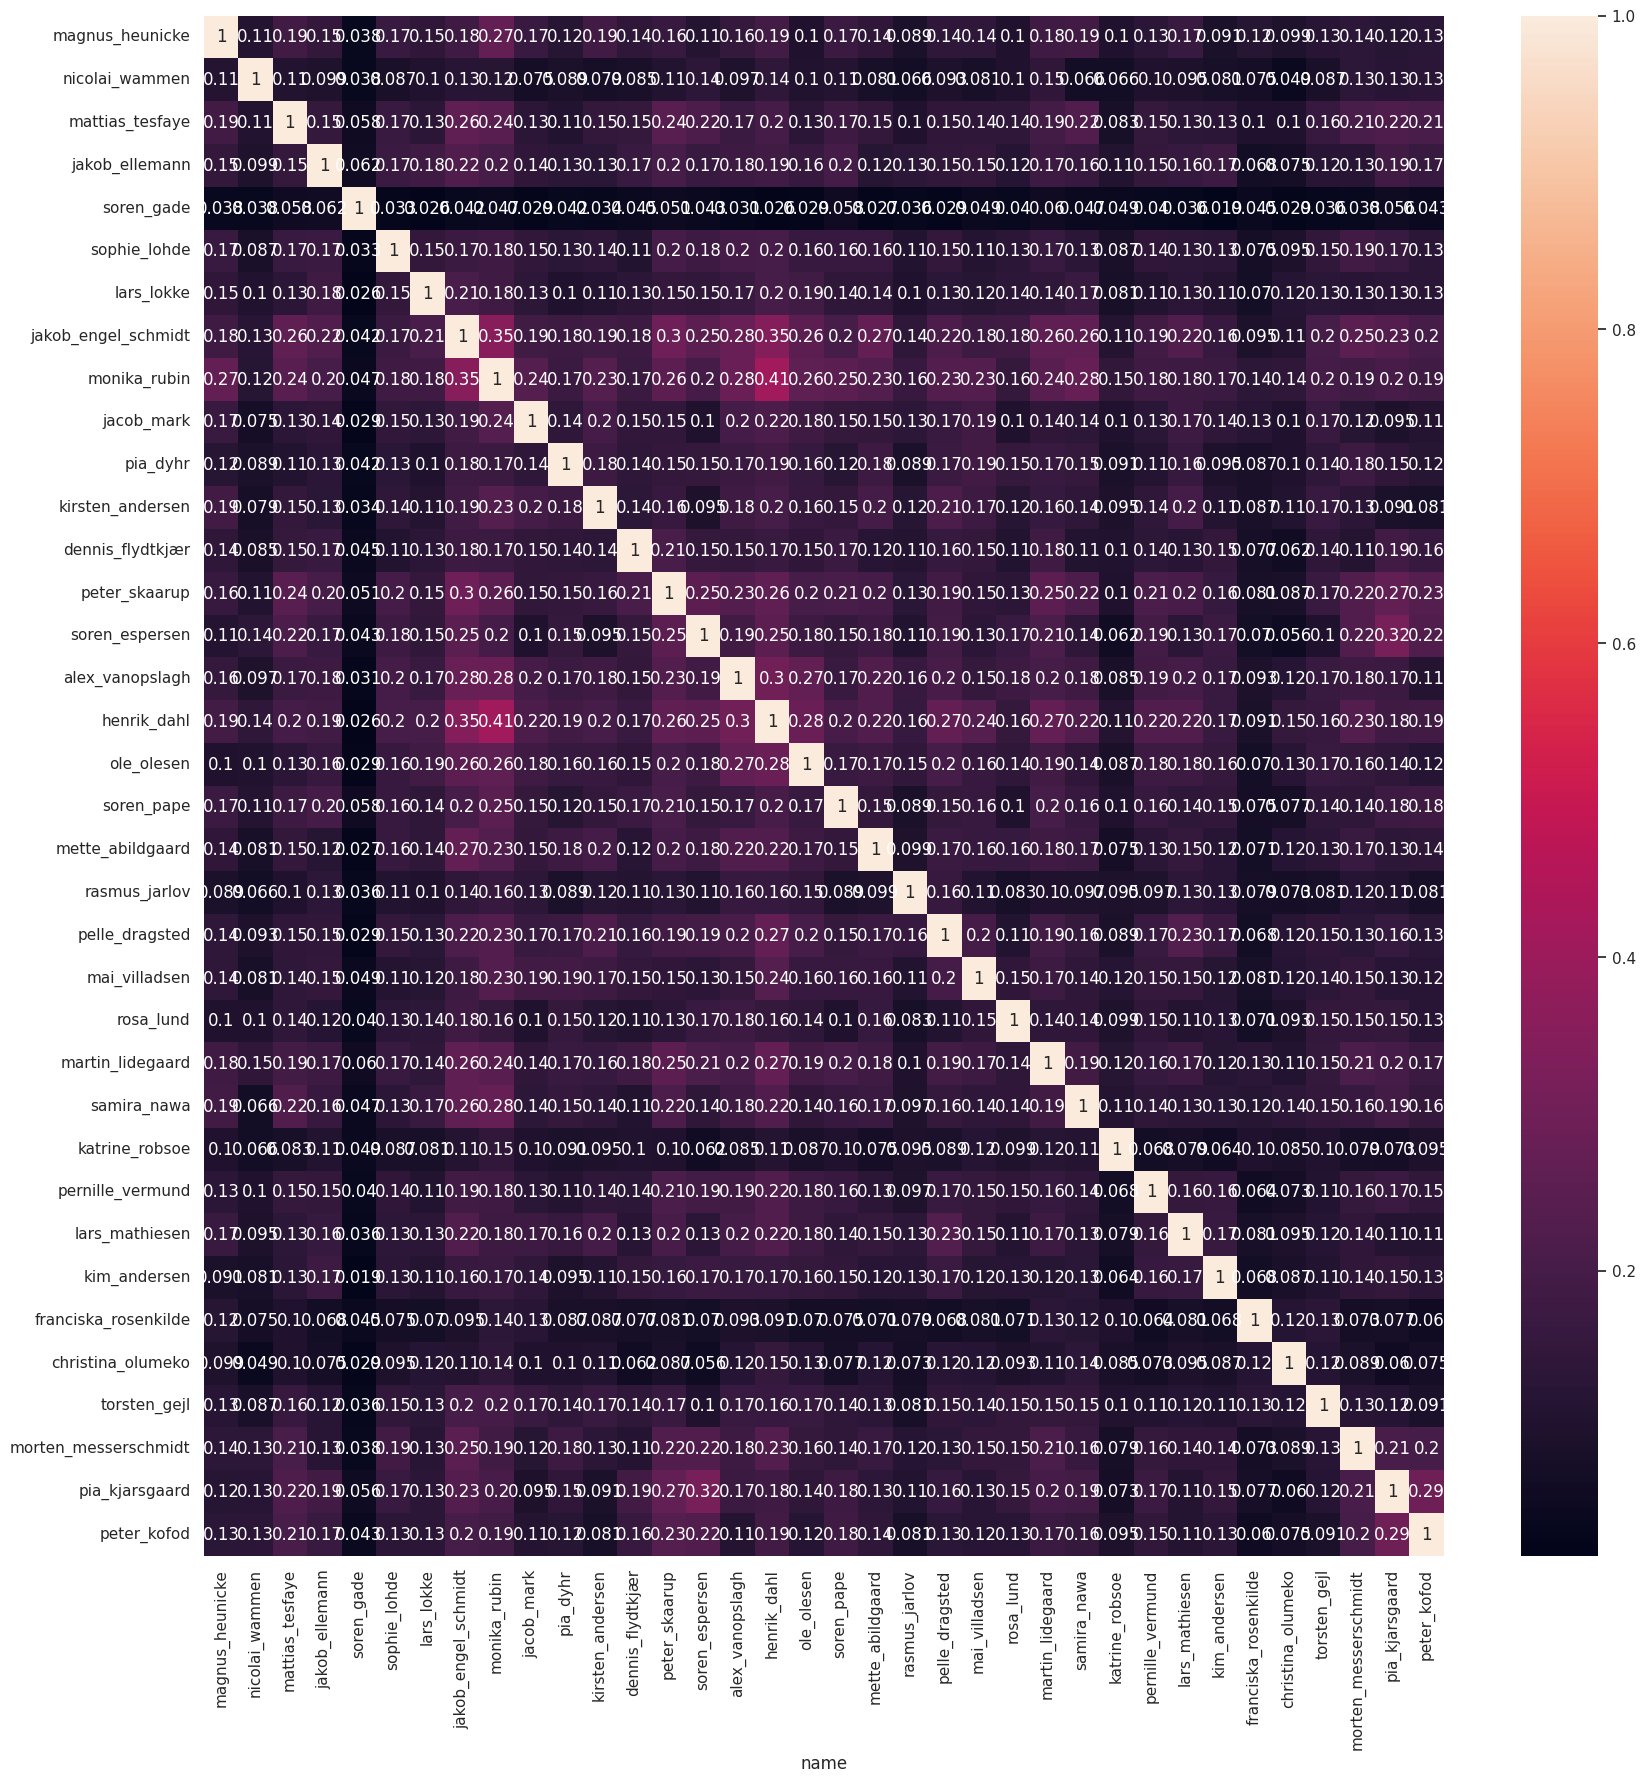

In [ ]:
import seaborn as sns
jac_sim = pd.DataFrame(partym_matrix, columns=data.name, index=data.name)
jac_sim.index.name = None
jac_sim

fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(jac_sim, ax=ax, xticklabels=True, yticklabels=True, annot=True)

In [ ]:
jac_sim_dist = jac_sim.apply(lambda x: 1-x)

In [ ]:
jac_sim_dist.to_csv("similarity_distance_minhash.csv")


1/42 - magnus_heunicke - Processing...
2/42 - nicolai_wammen - Processing...
3/42 - mattias_tesfaye - Processing...
4/42 - jakob_ellemann - Processing...
5/42 - soren_gade - Processing...
6/42 - sophie_lohde - Processing...
7/42 - lars_lokke - Processing...
8/42 - jakob_engel_schmidt - Processing...
9/42 - monika_rubin - Processing...
10/42 - jacob_mark - Processing...
11/42 - pia_dyhr - Processing...
12/42 - kirsten_andersen - Processing...
13/42 - dennis_flydtkjær - Processing...
14/42 - peter_skaarup - Processing...
15/42 - soren_espersen - Processing...
16/42 - alex_vanopslagh - Processing...
17/42 - henrik_dahl - Processing...
18/42 - ole_olesen - Processing...
19/42 - soren_pape - Processing...
20/42 - mette_abildgaard - Processing...
21/42 - rasmus_jarlov - Processing...
22/42 - pelle_dragsted - Processing...
23/42 - mai_villadsen - Processing...
24/42 - rosa_lund - Processing...
25/42 - martin_lidegaard - Processing...
26/42 - samira_nawa - Processing...
27/42 - katrine_robsoe 

<AxesSubplot: xlabel='name'>

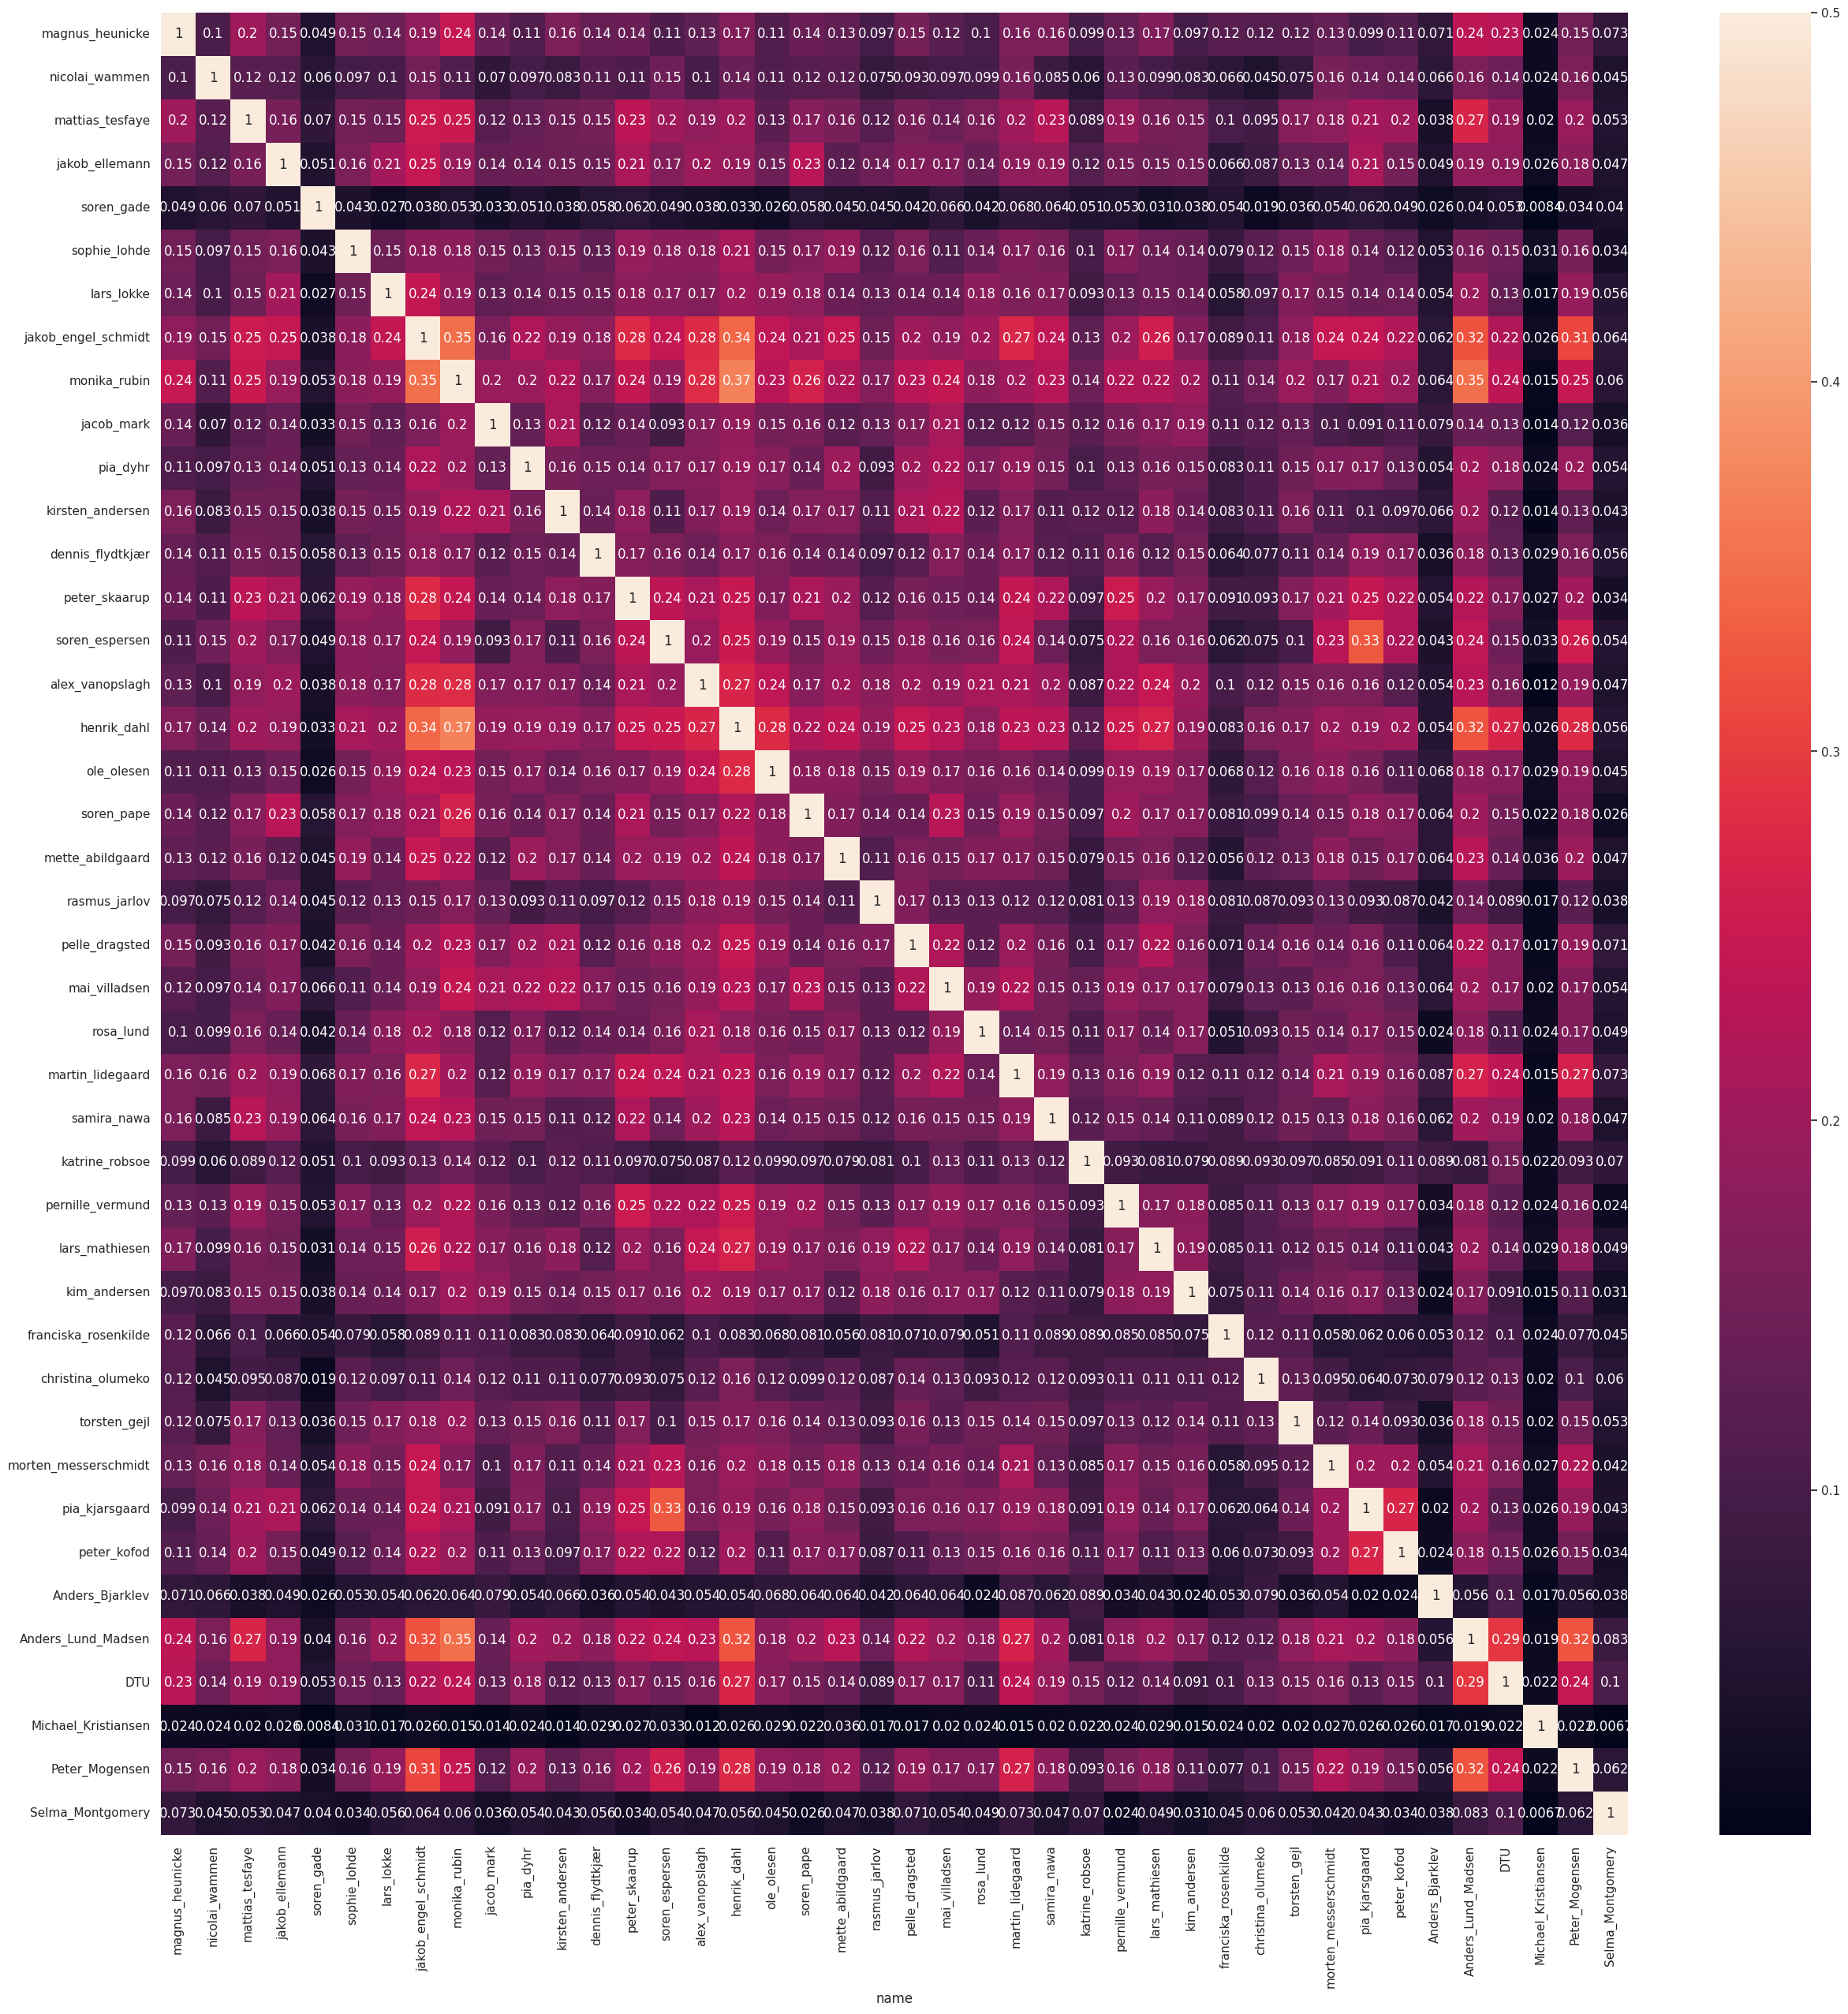

In [ ]:
#data include

dict_docs,signature_dict = create_docs(data_include,'name','TFIDF_Words')

n_partym = data_include.name.unique()
partym_matrix = np.zeros((len(n_partym), len(n_partym)))
for i, partm in enumerate(n_partym):
    for j, partm_next in enumerate(n_partym):
        #append to matrix 
        partym_matrix[i,j] = jaccard(data_include.name.iloc[i], data_include.name.iloc[j], signature_dict)

import seaborn as sns
jac_sim_include = pd.DataFrame(partym_matrix, columns=data_include.name, index=data_include.name)
jac_sim_include.index.name = None
jac_sim_include

fig, ax = plt.subplots(figsize = (30,30))
sns.heatmap(jac_sim_include, ax=ax, xticklabels=True, vmax = 0.5, yticklabels=True, annot=True)

In [ ]:
jac_dist_include = jac_sim_include.apply(lambda x: 1-x)

In [ ]:
jac_dist_include

name,magnus_heunicke,nicolai_wammen,mattias_tesfaye,jakob_ellemann,soren_gade,sophie_lohde,lars_lokke,jakob_engel_schmidt,monika_rubin,jacob_mark,...,torsten_gejl,morten_messerschmidt,pia_kjarsgaard,peter_kofod,Anders_Bjarklev,Anders_Lund_Madsen,DTU,Michael_Kristiansen,Peter_Mogensen,Selma_Montgomery
magnus_heunicke,0.000000,0.895028,0.800000,0.848369,0.951049,0.850575,0.857143,0.814229,0.755187,0.861480,...,0.880597,0.865784,0.901099,0.888889,0.928571,0.762887,0.767967,0.976109,0.850575,0.926655
nicolai_wammen,0.895028,0.000000,0.880597,0.884758,0.939929,0.903108,0.899083,0.850575,0.890943,0.930481,...,0.924731,0.843931,0.857143,0.863636,0.934281,0.837209,0.857143,0.976109,0.837209,0.954704
mattias_tesfaye,0.800000,0.880597,0.000000,0.841699,0.930481,0.850575,0.854962,0.747390,0.750000,0.878505,...,0.825832,0.816568,0.792757,0.800000,0.961938,0.728814,0.809524,0.979592,0.804781,0.947368
jakob_ellemann,0.848369,0.884758,0.841699,0.000000,0.949212,0.837209,0.792757,0.752599,0.807157,0.863636,...,0.867925,0.863636,0.785425,0.846154,0.951049,0.814229,0.814229,0.974359,0.821218,0.952880
soren_gade,0.951049,0.939929,0.930481,0.949212,0.000000,0.956522,0.972603,0.961938,0.947368,0.967298,...,0.963731,0.945518,0.938053,0.951049,0.974359,0.960139,0.947368,0.991597,0.965517,0.960139
sophie_lohde,0.850575,0.903108,0.850575,0.837209,0.956522,0.000000,0.854962,0.818898,0.823529,0.850575,...,0.852772,0.818898,0.863636,0.882682,0.947368,0.841699,0.852772,0.969072,0.841699,0.965517
lars_lokke,0.857143,0.899083,0.854962,0.792757,0.972603,0.854962,0.000000,0.757764,0.811881,0.870056,...,0.832685,0.848369,0.861480,0.857143,0.945518,0.802395,0.867925,0.983051,0.809524,0.943662
jakob_engel_schmidt,0.814229,0.850575,0.747390,0.752599,0.961938,0.818898,0.757764,0.000000,0.648649,0.839458,...,0.816568,0.755187,0.755187,0.780488,0.938053,0.678414,0.778004,0.974359,0.689956,0.936170
monika_rubin,0.755187,0.890943,0.750000,0.807157,0.947368,0.823529,0.811881,0.648649,0.000000,0.804781,...,0.804781,0.834951,0.785425,0.804781,0.936170,0.648649,0.762887,0.984772,0.752599,0.939929
jacob_mark,0.861480,0.930481,0.878505,0.863636,0.967298,0.850575,0.870056,0.839458,0.804781,0.000000,...,0.867925,0.895028,0.909091,0.892989,0.920863,0.861480,0.865784,0.986486,0.884758,0.963731


In [ ]:
jac_dist_include.to_csv("similarity_distance_minhash_all.csv")


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=30797f9c-952e-45b4-98d4-31c9ac73ae78' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>